## Project 2: Pemodelan Prediktif untuk Mengestimasi Total Kerugian Finansial (All Costs) dari Sebuah Insiden
Tujuan utama dari proyek ini adalah membangun sebuah model machine learning yang mampu memprediksi atau mengestimasi total kerugian finansial (All Costs) yang diakibatkan oleh sebuah insiden kecelakaan pipa. Dengan model ini, kita berharap dapat lebih memahami faktor-faktor apa saja yang paling signifikan mempengaruhi besarnya biaya dan, idealnya, dapat memberikan perkiraan biaya untuk insiden baru berdasarkan karakteristiknya.

Secara garis besar, kita akan melalui tahapan berikut:
1. Persiapan Data Lanjutan untuk Pemodelan: Ini mencakup pemilihan fitur yang relevan, penanganan nilai hilang yang mungkin masih ada atau perlu perlakuan khusus untuk pemodelan, pengkodean (encoding) variabel kategorikal, pembagian data menjadi set pelatihan dan pengujian, serta penskalaan fitur.
2. Pemilihan dan Pelatihan Model Regresi: Kita akan mengeksplorasi beberapa algoritma regresi dan melatihnya menggunakan data yang telah kita siapkan.
3. Evaluasi Model: Mengukur seberapa baik model kita dalam memprediksi total biaya menggunakan metrik evaluasi yang sesuai.
4. Interpretasi Hasil dan Kesimpulan: Menganalisis hasil model, memahami fitur mana yang paling berpengaruh, dan menarik kesimpulan.

### Tahap 1: Persiapan Data Lanjutan untuk Pemodelan
#### 1.1: Memuat Data, Seleksi Fitur, dan Persiapan Awal Target Variabel

 langkah pertama adalah memuat dataset yang telah kita bersihkan dan rekayasa fiturnya pada Proyek 1. File pipeline_accidents_processed_eda.csv akan menjadi fondasi kita.

Setelah data dimuat, kita perlu menentukan fitur-fitur (kolom) mana yang akan kita gunakan sebagai input (prediktor) untuk model kita, dan mana yang akan menjadi target prediksi. Dalam kasus ini, target kita adalah kolom All Costs.

Berdasarkan pemahaman domain dan temuan dari EDA, kita akan memilih serangkaian fitur awal yang kita anggap berpotensi mempengaruhi total biaya. Fitur-fitur ini mencakup karakteristik insiden, jenis pipa, jenis cairan, penyebab, dampak fisik, serta informasi waktu. Kita juga akan menyertakan Operator Name dan Accident City seperti diskusi kita sebelumnya, meskipun kita sadar bahwa fitur kategorikal dengan banyak nilai unik ini akan memerlukan penanganan khusus pada tahap encoding nanti.

Variabel target All Costs seringkali memiliki distribusi yang sangat miring (skewed), di mana sebagian besar nilainya kecil dan ada beberapa nilai yang sangat besar. Distribusi seperti ini dapat menyulitkan beberapa algoritma machine learning. Oleh karena itu, kita akan memeriksa distribusinya dan menerapkan transformasi logaritmik (log1p untuk mengakomodasi nilai nol) untuk membuatnya lebih mendekati distribusi normal, yang diharapkan dapat membantu performa model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
                
nama_file_input = 'pipeline_accidents_processed_eda.csv'
df_model = pd.read_csv(nama_file_input)
print(f"DataFrame berhasil dimuat dari '{nama_file_input}'.")
print(f"Dimensi data: {df_model.shape[0]} baris dan {df_model.shape[1]} kolom.")

DataFrame berhasil dimuat dari 'pipeline_accidents_processed_eda.csv'.
Dimensi data: 2795 baris dan 62 kolom.


In [2]:
print("\nContoh 5 baris pertama data yang dimuat:")
print(df_model.head().to_string())


Contoh 5 baris pertama data yang dimuat:
   Report Number  Supplemental Number  Accident Year   Accident Date/Time  Operator ID                Operator Name Pipeline/Facility Name Pipeline Location Pipeline Type Liquid Type Liquid Subtype Liquid Name   Accident City               Accident County Accident State  Accident Latitude  Accident Longitude               Cause Category                      Cause Subcategory  Unintentional Release (Barrels)  Intentional Release (Barrels)  Liquid Recovery (Barrels)  Net Loss (Barrels) Liquid Ignition Liquid Explosion Pipeline Shutdown   Shutdown Date/Time    Restart Date/Time  Public Evacuations  Operator Employee Injuries  Operator Contractor Injuries  Emergency Responder Injuries  Other Injuries  Public Injuries  All Injuries  Operator Employee Fatalities  Operator Contractor Fatalities  Emergency Responder Fatalities  Other Fatalities  Public Fatalities  All Fatalities  Property Damage Costs  Lost Commodity Costs  Public/Private Property Dama

In [3]:
predictor_cols = [
    'Operator Name', 'Accident City', 'Pipeline Location', 'Pipeline Type', 
    'Liquid Type', 'Cause Category', 'Is_HVL', 'Unintentional Release (Barrels)', 
    'Net Loss (Barrels)', 'Public Evacuations', 'All Injuries', 'All Fatalities', 
    'Recovery_Rate', 'Accident_Year', 'Accident_Month', 'Accident_Hour', 
    'Shutdown_Duration_Hours', 'Cost_per_Barrel_Lost'
]
    
features_to_exclude_due_to_leakage = ['Cost_per_Barrel_Lost', 'Avg_AllCosts_Operator']
predictor_cols = [col for col in predictor_cols if col not in features_to_exclude_due_to_leakage]

existing_predictor_cols = [col for col in predictor_cols if col in df_model.columns]
missing_from_selection = set(predictor_cols) - set(existing_predictor_cols)
if missing_from_selection:
    print(f"\nPeringatan: Kolom berikut dari daftar pilihan awal tidak ditemukan di DataFrame dan akan diabaikan: {missing_from_selection}")

if not existing_predictor_cols or 'All Costs' not in df_model.columns:
    print("\nTidak dapat melanjutkan: Kolom prediktor penting atau target 'All Costs' tidak ditemukan dalam DataFrame.")
else:
    X = df_model[existing_predictor_cols].copy()
    y = df_model['All Costs'].copy()

    print(f"\nJumlah fitur prediktor yang akan digunakan: {len(X.columns)}")
    print(f"Nama fitur prediktor: {X.columns.tolist()}")


Jumlah fitur prediktor yang akan digunakan: 17
Nama fitur prediktor: ['Operator Name', 'Accident City', 'Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Cause Category', 'Is_HVL', 'Unintentional Release (Barrels)', 'Net Loss (Barrels)', 'Public Evacuations', 'All Injuries', 'All Fatalities', 'Recovery_Rate', 'Accident_Year', 'Accident_Month', 'Accident_Hour', 'Shutdown_Duration_Hours']


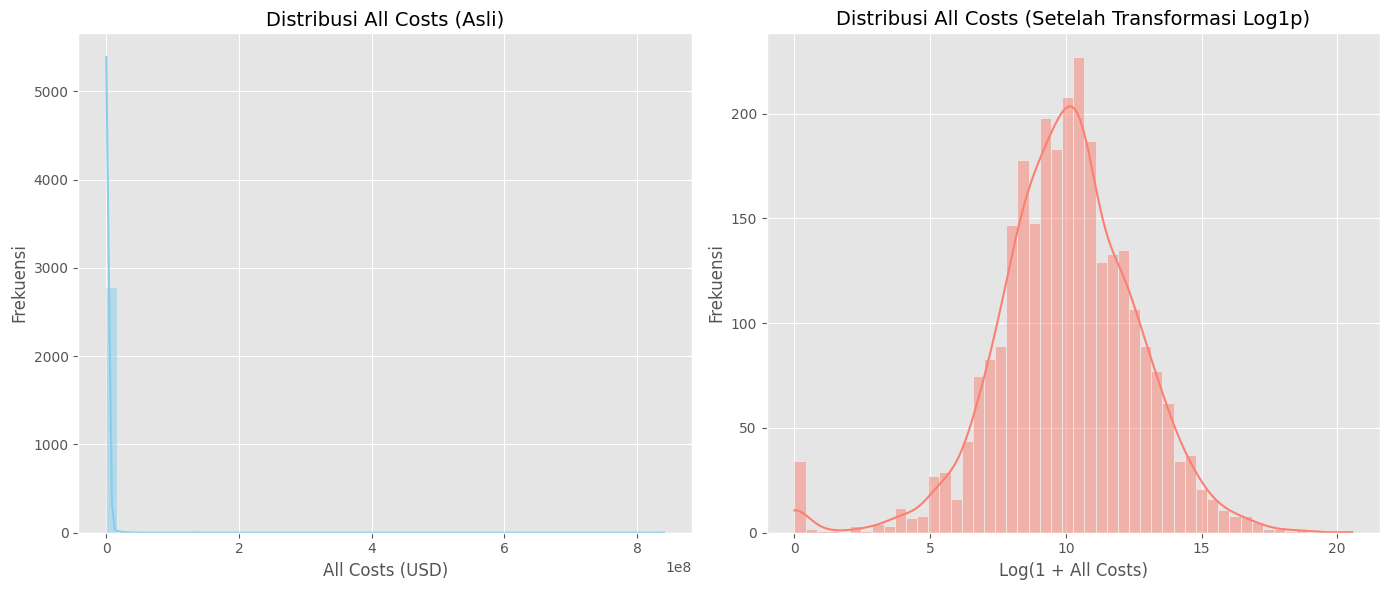


Statistik Deskriptif 'All Costs' (Asli):
count          2,795.00
mean         834,033.25
std       16,578,298.48
min                0.00
25%            5,039.50
50%           23,129.00
75%          117,232.50
max      840,526,118.00
Name: All Costs, dtype: object

Statistik Deskriptif 'All Costs' (Setelah Transformasi Log1p):
count    2,795.00
mean        10.01
std          2.63
min          0.00
25%          8.53
50%         10.05
75%         11.67
max         20.55
Name: All Costs, dtype: object


In [4]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=50, color='skyblue')
plt.title('Distribusi All Costs (Asli)', fontsize=14)
plt.xlabel('All Costs (USD)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
        
y_transformed = np.log1p(y)
        
plt.subplot(1, 2, 2)
sns.histplot(y_transformed, kde=True, bins=50, color='salmon')
plt.title('Distribusi All Costs (Setelah Transformasi Log1p)', fontsize=14)
plt.xlabel('Log(1 + All Costs)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.tight_layout()
plt.show()

print("\nStatistik Deskriptif 'All Costs' (Asli):")
print(y.describe().apply(lambda x: f"{x:,.2f}"))
print("\nStatistik Deskriptif 'All Costs' (Setelah Transformasi Log1p):")
print(y_transformed.describe().apply(lambda x: f"{x:,.2f}"))
        
y_model = y_transformed

In [5]:
print("\nContoh 5 baris pertama dari Fitur (X) yang dipilih:")
print(X.head().to_string())
print("\nContoh 5 baris pertama dari Target (y_model) yang ditransformasi:")
print(y_model.head().to_string())


Contoh 5 baris pertama dari Fitur (X) yang dipilih:
                 Operator Name   Accident City Pipeline Location Pipeline Type Liquid Type               Cause Category  Is_HVL  Unintentional Release (Barrels)  Net Loss (Barrels)  Public Evacuations  All Injuries  All Fatalities  Recovery_Rate  Accident_Year  Accident_Month  Accident_Hour  Shutdown_Duration_Hours
0  ALYESKA PIPELINE SERVICE CO  DELTA JUNCTION           ONSHORE          TANK   CRUDE OIL          INCORRECT OPERATION       0                          2580.00              1119.0                 0.0           0.0             0.0       0.566279           2010               5             11                77.666667
1  ALYESKA PIPELINE SERVICE CO        COLDFOOT           ONSHORE   ABOVEGROUND   CRUDE OIL  MATERIAL/WELD/EQUIP FAILURE       0                             0.12                 0.0                 0.0           0.0             0.0       1.000000           2010               9             14                -1.000

##### 1.2: Encoding Variabel Kategorikal
Model machine learning memerlukan input numerik. Oleh karena itu, fitur-fitur kategorikal dalam dataset kita (seperti Operator Name, Accident City, Pipeline Location, Pipeline Type, Liquid Type, Cause Category) perlu diubah menjadi representasi numerik. 

kita akan menggunakan:
- Frequency Encoding untuk fitur dengan kardinalitas sangat tinggi seperti Operator Name dan Accident City.
- One-Hot Encoding untuk fitur kategorikal lainnya dengan kardinalitas lebih terkendali.

In [6]:
if 'X' in locals() and not X.empty:
    X_encoded = X.copy() 
    
    categorical_cols = X_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    high_cardinality_threshold = 50 
    high_cardinality_cols = []
    low_cardinality_categorical_cols = []

    for col in categorical_cols:
        if X_encoded[col].nunique() > high_cardinality_threshold:
            if col in ['Operator Name', 'Accident City']:
                 high_cardinality_cols.append(col)
            else:
                 low_cardinality_categorical_cols.append(col)
        else:
            low_cardinality_categorical_cols.append(col)
            
    print(f"Kolom untuk Frequency Encoding: {high_cardinality_cols}")
    print(f"Kolom untuk One-Hot Encoding: {low_cardinality_categorical_cols}")

    # 1. Frequency Encoding
    for col in high_cardinality_cols:
        if col in X_encoded.columns:
            frequency_map = X_encoded[col].value_counts(normalize=True)
            X_encoded[col + '_freq_encoded'] = X_encoded[col].map(frequency_map)
            X_encoded.drop(col, axis=1, inplace=True)
            print(f"Kolom '{col}' di-encode menggunakan Frequency Encoding menjadi '{col}_freq_encoded'.")

    # 2. One-Hot Encoding
    if low_cardinality_categorical_cols:
        X_encoded = pd.get_dummies(X_encoded, columns=low_cardinality_categorical_cols, drop_first=True)
        print(f"Kolom {low_cardinality_categorical_cols} di-encode menggunakan One-Hot Encoding.")
    
    print("\nDimensi X setelah encoding:", X_encoded.shape)
    print("Contoh 5 baris pertama X setelah encoding:")
    print(X_encoded.head().to_string())
    
    final_feature_columns = X_encoded.columns.tolist()
else:
    print("DataFrame X belum terdefinisi atau kosong. Jalankan langkah sebelumnya.")

Kolom untuk Frequency Encoding: ['Operator Name', 'Accident City']
Kolom untuk One-Hot Encoding: ['Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Cause Category']
Kolom 'Operator Name' di-encode menggunakan Frequency Encoding menjadi 'Operator Name_freq_encoded'.
Kolom 'Accident City' di-encode menggunakan Frequency Encoding menjadi 'Accident City_freq_encoded'.
Kolom ['Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Cause Category'] di-encode menggunakan One-Hot Encoding.

Dimensi X setelah encoding: (2795, 28)
Contoh 5 baris pertama X setelah encoding:
   Is_HVL  Unintentional Release (Barrels)  Net Loss (Barrels)  Public Evacuations  All Injuries  All Fatalities  Recovery_Rate  Accident_Year  Accident_Month  Accident_Hour  Shutdown_Duration_Hours  Operator Name_freq_encoded  Accident City_freq_encoded  Pipeline Location_ONSHORE  Pipeline Type_TANK  Pipeline Type_TRANSITION AREA  Pipeline Type_UNDERGROUND  Pipeline Type_UNKNOWN  Liquid Type_CO2 (CARBON DIOXIDE)  Liquid Typ

##### 1.3: Pembagian Data (Train-Test Split)
Kita akan membagi data 80% untuk training dan 20% untuk testing

In [7]:
from sklearn.model_selection import train_test_split
print("\nMelakukan pembagian data menjadi set pelatihan dan pengujian...")
    
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_model, test_size=0.2, random_state=42)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")
    
print("\nContoh 5 baris pertama dari X_train:")
print(X_train.head().to_string())
print("\nContoh 5 baris pertama dari y_train:")
print(y_train.head().to_string())


Melakukan pembagian data menjadi set pelatihan dan pengujian...
Ukuran X_train: (2236, 28)
Ukuran X_test: (559, 28)
Ukuran y_train: (2236,)
Ukuran y_test: (559,)

Contoh 5 baris pertama dari X_train:
      Is_HVL  Unintentional Release (Barrels)  Net Loss (Barrels)  Public Evacuations  All Injuries  All Fatalities  Recovery_Rate  Accident_Year  Accident_Month  Accident_Hour  Shutdown_Duration_Hours  Operator Name_freq_encoded  Accident City_freq_encoded  Pipeline Location_ONSHORE  Pipeline Type_TANK  Pipeline Type_TRANSITION AREA  Pipeline Type_UNDERGROUND  Pipeline Type_UNKNOWN  Liquid Type_CO2 (CARBON DIOXIDE)  Liquid Type_CRUDE OIL  Liquid Type_HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS  Liquid Type_REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID  Cause Category_CORROSION  Cause Category_EXCAVATION DAMAGE  Cause Category_INCORRECT OPERATION  Cause Category_MATERIAL/WELD/EQUIP FAILURE  Cause Category_NATURAL FORCE DAMAGE  Cause Category_OTHER OUTSIDE FORCE DAMAGE
157        1    

##### 1.4: Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler
if 'X_train' in locals() and 'X_test' in locals() and not X_train.empty:
    print("\nMelakukan penskalaan fitur numerik...")

    numerical_cols_to_scale = X_train.select_dtypes(include=np.number).columns.tolist()

    if not numerical_cols_to_scale:
        print("Tidak ada kolom numerik yang teridentifikasi untuk penskalaan di X_train.")
    else:
        print(f"Kolom numerik yang akan diskalakan: {numerical_cols_to_scale}")

        scaler = StandardScaler()

        X_train_scaled_array = scaler.fit_transform(X_train[numerical_cols_to_scale])
        
        X_test_scaled_array = scaler.transform(X_test[numerical_cols_to_scale])

        X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=numerical_cols_to_scale, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=numerical_cols_to_scale, index=X_test.index)
        
        X_train_processed = X_train_scaled
        X_test_processed = X_test_scaled

        print("\nDimensi X_train setelah penskalaan:", X_train_processed.shape)
        print("Contoh 5 baris pertama X_train setelah penskalaan:")
        print(X_train_processed.head().to_string())

        print("\nDimensi X_test setelah penskalaan:", X_test_processed.shape)
        print("Contoh 5 baris pertama X_test setelah penskalaan:")
        print(X_test_processed.head().to_string())
else:
    print("DataFrame X_train atau X_test belum terdefinisi. Jalankan langkah pembagian data terlebih dahulu.")



Melakukan penskalaan fitur numerik...
Kolom numerik yang akan diskalakan: ['Is_HVL', 'Unintentional Release (Barrels)', 'Net Loss (Barrels)', 'Public Evacuations', 'All Injuries', 'All Fatalities', 'Recovery_Rate', 'Accident_Year', 'Accident_Month', 'Accident_Hour', 'Shutdown_Duration_Hours', 'Operator Name_freq_encoded', 'Accident City_freq_encoded']

Dimensi X_train setelah penskalaan: (2236, 13)
Contoh 5 baris pertama X_train setelah penskalaan:
        Is_HVL  Unintentional Release (Barrels)  Net Loss (Barrels)  Public Evacuations  All Injuries  All Fatalities  Recovery_Rate  Accident_Year  Accident_Month  Accident_Hour  Shutdown_Duration_Hours  Operator Name_freq_encoded  Accident City_freq_encoded
157   1.033661                        -0.155987           -0.111816           -0.050478     -0.056837       -0.044906       0.777825       0.933266       -0.931500      -1.352924                -0.028495                    0.516664                   -0.249090
1961  1.033661            

#### Tahap 2: Pemilihan dan Pelatihan Model Regresi
Kita akan memulai dengan beberapa model yang umum digunakan untuk tugas regresi:
1. Regresi Linear (Linear Regression): Sebagai model dasar (baseline) untuk perbandingan.
2. Random Forest Regressor: Model ensemble yang kuat dan sering memberikan hasil baik, serta dapat memberikan informasi mengenai pentingnya fitur.
3. Gradient Boosting Regressor: Model ensemble lain yang juga sangat powerful dan seringkali menjadi salah satu model dengan performa terbaik.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

if 'X_train_processed' in locals() and 'y_train' in locals() and 'X_test_processed' in locals():
    print("Memulai pelatihan model regresi awal...")

    # 1. Regresi Linear
    lr_model = LinearRegression()

    # 2. Decision Tree Regressor (sebagai baseline yang lebih kompleks dari linear)
    dt_model = DecisionTreeRegressor(random_state=42)

    # 3. Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10) 

    # 4. Gradient Boosting Regressor
    gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, min_samples_split=10)

    models = {
        "Linear Regression": lr_model,
        "Decision Tree": dt_model,
        "Random Forest": rf_model,
        "Gradient Boosting": gbr_model
    }

    predictions_test = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\nMelatih model: {name}...")
        try:
            model.fit(X_train_processed, y_train)
            y_pred_test = model.predict(X_test_processed)
            
            predictions_test[name] = y_pred_test
            trained_models[name] = model
            
            print(f"Model {name} berhasil dilatih dan prediksi pada data tes dibuat.")
            print(f"Contoh 5 prediksi pertama dari {name} (pada skala log): {y_pred_test[:5]}")
        except Exception as e:
            print(f"Error saat melatih atau memprediksi dengan {name}: {e}")
            predictions_test[name] = None
            trained_models[name] = None

    print("\nPelatihan semua model awal selesai.")
else:
    print("Data pelatihan (X_train_processed, y_train) atau data tes (X_test_processed) belum terdefinisi. Jalankan langkah persiapan data terlebih dahulu.")


Memulai pelatihan model regresi awal...

Melatih model: Linear Regression...
Model Linear Regression berhasil dilatih dan prediksi pada data tes dibuat.
Contoh 5 prediksi pertama dari Linear Regression (pada skala log): [ 9.4728858  10.18973694  7.54753351 10.00132084  9.85717167]

Melatih model: Decision Tree...
Model Decision Tree berhasil dilatih dan prediksi pada data tes dibuat.
Contoh 5 prediksi pertama dari Decision Tree (pada skala log): [ 7.91971976  9.82558006 12.79975854  4.2341065  12.98723299]

Melatih model: Random Forest...
Model Random Forest berhasil dilatih dan prediksi pada data tes dibuat.
Contoh 5 prediksi pertama dari Random Forest (pada skala log): [ 7.22778078 10.08792946 13.29301076  7.32093865 12.48940947]

Melatih model: Gradient Boosting...
Model Gradient Boosting berhasil dilatih dan prediksi pada data tes dibuat.
Contoh 5 prediksi pertama dari Gradient Boosting (pada skala log): [ 7.79504171 10.3679447  11.01717744  6.89155079 13.34384181]

Pelatihan semua

##### 2.2: Evaluasi Model Regresi

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if 'y_test' in locals() and 'predictions_test' in locals() and predictions_test:
    print("Memulai evaluasi model regresi...")

    results_summary = []

    for name, y_pred_log in predictions_test.items():
        if y_pred_log is None:
            print(f"\nModel {name} tidak berhasil dilatih atau membuat prediksi, evaluasi dilewati.")
            continue

        print(f"\n--- Mengevaluasi Model: {name} ---")

        mae_log = mean_absolute_error(y_test, y_pred_log)
        mse_log = mean_squared_error(y_test, y_pred_log)
        rmse_log = np.sqrt(mse_log)
        r2_log = r2_score(y_test, y_pred_log)

        print("Metrik pada Skala Logaritmik:")
        print(f"  Mean Absolute Error (MAE): {mae_log:.4f}")
        print(f"  Mean Squared Error (MSE): {mse_log:.4f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse_log:.4f}")
        print(f"  R-squared (R²): {r2_log:.4f}")

        y_test_original = np.expm1(y_test)
        y_pred_original = np.expm1(y_pred_log)
        
        y_pred_original[y_pred_original < 0] = 0

        mae_original = mean_absolute_error(y_test_original, y_pred_original)
        mse_original = mean_squared_error(y_test_original, y_pred_original)
        rmse_original = np.sqrt(mse_original)
        r2_original = r2_score(y_test_original, y_pred_original)


        print("\nMetrik pada Skala Asli (USD):")
        print(f"  Mean Absolute Error (MAE): ${mae_original:,.2f}")
        print(f"  Root Mean Squared Error (RMSE): ${rmse_original:,.2f}")
        print(f"  R-squared (R²) (pada skala asli): {r2_original:.4f}")
        
        results_summary.append({
            "Model": name,
            "MAE (Log)": mae_log,
            "RMSE (Log)": rmse_log,
            "R² (Log)": r2_log,
            "MAE (Original USD)": mae_original,
            "RMSE (Original USD)": rmse_original,
            "R² (Original USD)": r2_original
        })

    if results_summary:
        results_df = pd.DataFrame(results_summary)
        print("\n\n" + "="*30 + " Ringkasan Hasil Evaluasi Model " + "="*30)
        results_df_display = results_df.copy()
        results_df_display['MAE (Original USD)'] = results_df_display['MAE (Original USD)'].map('${:,.2f}'.format)
        results_df_display['RMSE (Original USD)'] = results_df_display['RMSE (Original USD)'].map('${:,.2f}'.format)
        results_df_display = results_df_display.round(4)
        print(results_df_display.to_string())

else:
    print("Variabel y_test atau predictions_test belum terdefinisi. Jalankan langkah pelatihan model terlebih dahulu.")

Memulai evaluasi model regresi...

--- Mengevaluasi Model: Linear Regression ---
Metrik pada Skala Logaritmik:
  Mean Absolute Error (MAE): 1.7569
  Mean Squared Error (MSE): 5.7039
  Root Mean Squared Error (RMSE): 2.3883
  R-squared (R²): 0.0822

Metrik pada Skala Asli (USD):
  Mean Absolute Error (MAE): $1,140,787.72
  Root Mean Squared Error (RMSE): $21,522,367.23
  R-squared (R²) (pada skala asli): -417.6648

--- Mengevaluasi Model: Decision Tree ---
Metrik pada Skala Logaritmik:
  Mean Absolute Error (MAE): 1.8814
  Mean Squared Error (MSE): 6.5779
  Root Mean Squared Error (RMSE): 2.5647
  R-squared (R²): -0.0585

Metrik pada Skala Asli (USD):
  Mean Absolute Error (MAE): $1,762,028.16
  Root Mean Squared Error (RMSE): $35,132,816.94
  R-squared (R²) (pada skala asli): -1114.6097

--- Mengevaluasi Model: Random Forest ---
Metrik pada Skala Logaritmik:
  Mean Absolute Error (MAE): 1.3226
  Mean Squared Error (MSE): 3.7910
  Root Mean Squared Error (RMSE): 1.9471
  R-squared (R²):

Dapat dilihat bahwa model Random Forest menjadi model yang terbaik.

##### 2.3: Interpretasi Model dan Analisis Fitur Penting
Langkah penting berikutnya adalah mencoba memahami mengapa model ini membuat prediksi seperti itu, yaitu dengan melihat fitur mana yang dianggap paling penting oleh model.

Model berbasis pohon seperti Random Forest memiliki atribut feature_importances_ yang memberikan skor untuk setiap fitur, menunjukkan seberapa besar kontribusi fitur tersebut dalam mengurangi ketidakmurnian (impurity) atau error pada prediksi di seluruh pohon dalam forest. Fitur dengan skor lebih tinggi dianggap lebih penting oleh model.

Kita akan mengambil model Random Forest yang telah dilatih (trained_models["Random Forest"]) dan memvisualisasikan fitur-fitur terpentingnya.

Menganalisis Fitur Penting dari Model Random Forest...

Top 15 Fitur Terpenting menurut Random Forest:
                            feature  importance
1   Unintentional Release (Barrels)    0.475596
10          Shutdown_Duration_Hours    0.151940
11       Operator Name_freq_encoded    0.085875
6                     Recovery_Rate    0.053897
9                     Accident_Hour    0.048506
12       Accident City_freq_encoded    0.044451
8                    Accident_Month    0.043994
2                Net Loss (Barrels)    0.035257
7                     Accident_Year    0.032508
4                      All Injuries    0.010947
0                            Is_HVL    0.007876
3                Public Evacuations    0.005791
5                    All Fatalities    0.003362


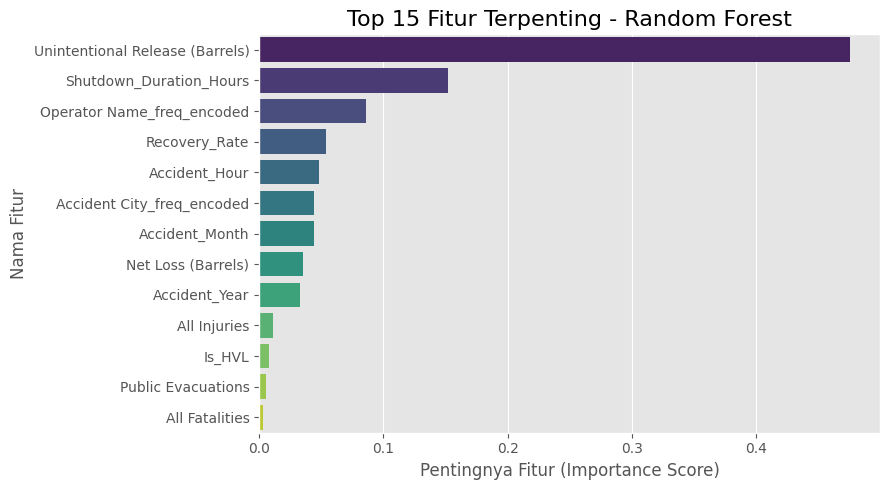

In [11]:
if 'trained_models' in locals() and "Random Forest" in trained_models and trained_models["Random Forest"] is not None and \
   'X_train_processed' in locals() and not X_train_processed.empty:
    
    print("Menganalisis Fitur Penting dari Model Random Forest...")
    
    rf_best_model = trained_models["Random Forest"]
    
    # Mendapatkan pentingnya fitur
    importances = rf_best_model.feature_importances_
    feature_names = X_train_processed.columns
    
    # Membuat DataFrame untuk visualisasi
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Menampilkan N fitur terpenting
    top_n_features = 15
    print(f"\nTop {top_n_features} Fitur Terpenting menurut Random Forest:")
    print(feature_importance_df.head(top_n_features).to_string())

    # Visualisasi Fitur Penting
    plt.figure(figsize=(9, 5))
    sns.barplot(x='importance', y='feature', 
                data=feature_importance_df.head(top_n_features), 
                hue='feature', palette='viridis', legend=False, dodge=False) # Menambahkan dodge=False
    plt.title(f'Top {top_n_features} Fitur Terpenting - Random Forest', fontsize=16)
    plt.xlabel('Pentingnya Fitur (Importance Score)', fontsize=12)
    plt.ylabel('Nama Fitur', fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("Model Random Forest belum dilatih atau X_train_processed tidak tersedia.")


#####  2.4: Penyetelan Hyperparameter (Hyperparameter Tuning)
Model Random Forest yang kita latih menggunakan parameter default (atau sedikit penyesuaian awal). Performa model seringkali dapat ditingkatkan dengan menyetel hyperparameter-nya. Hyperparameter adalah parameter yang nilainya diatur sebelum proses pelatihan model dimulai (misalnya, n_estimators, max_depth, min_samples_split pada Random Forest).

Teknik umum untuk penyetelan hyperparameter adalah Grid Search atau Randomized Search.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

if 'X_train_processed' in locals() and 'y_train' in locals() and \
   'X_test_processed' in locals() and 'y_test' in locals() and \
   'trained_models' in locals() and "Random Forest" in trained_models and \
   trained_models["Random Forest"] is not None:

    print("\nMemulai Penyetelan Hyperparameter untuk Random Forest...")

    param_dist_rf = {
        'n_estimators': [100, 150, 200, 250, 300],       # Jumlah pohon
        'max_depth': [10, 15, 20, 25, None],             # Kedalaman maksimum pohon
        'min_samples_split': [5, 10, 15, 20],            # Jumlah minimum sampel untuk membagi node
        'min_samples_leaf': [2, 4, 6, 8],                # Jumlah minimum sampel pada leaf node
        'max_features': ['sqrt', 'log2', 0.7, 0.8, None] # Jumlah fitur yang dipertimbangkan
    }

    rf_base_for_tuning = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    rf_random_search = RandomizedSearchCV(estimator=rf_base_for_tuning, 
                                          param_distributions=param_dist_rf, 
                                          n_iter=25, 
                                          cv=3,     
                                          verbose=1, 
                                          random_state=42, 
                                          n_jobs=-1, 
                                          scoring='neg_root_mean_squared_error')

    try:
        rf_random_search.fit(X_train_processed, y_train)

        print("\nPenyetelan Hyperparameter Selesai.")
        print("Parameter Terbaik yang Ditemukan untuk Random Forest:")
        print(rf_random_search.best_params_)
        
        best_rf_model_tuned = rf_random_search.best_estimator_
        
        trained_models["Random Forest Tuned"] = best_rf_model_tuned
        
        print("\n--- Mengevaluasi Model Random Forest (Setelah Tuning) ---")
        y_pred_test_tuned = best_rf_model_tuned.predict(X_test_processed)
        
        mae_log_tuned = mean_absolute_error(y_test, y_pred_test_tuned)
        rmse_log_tuned = np.sqrt(mean_squared_error(y_test, y_pred_test_tuned))
        r2_log_tuned = r2_score(y_test, y_pred_test_tuned)
        print("Metrik pada Skala Logaritmik (Tuned):")
        print(f"  MAE: {mae_log_tuned:.4f}, RMSE: {rmse_log_tuned:.4f}, R²: {r2_log_tuned:.4f}")

        y_test_original_tuned = np.expm1(y_test) 
        y_pred_original_tuned = np.expm1(y_pred_test_tuned)
        y_pred_original_tuned[y_pred_original_tuned < 0] = 0 
        
        mae_original_tuned = mean_absolute_error(y_test_original_tuned, y_pred_original_tuned)
        rmse_original_tuned = np.sqrt(mean_squared_error(y_test_original_tuned, y_pred_original_tuned))
        r2_original_tuned = r2_score(y_test_original_tuned, y_pred_original_tuned)
        print("\nMetrik pada Skala Asli (USD) (Tuned):")
        print(f"  MAE: ${mae_original_tuned:,.2f}, RMSE: ${rmse_original_tuned:,.2f}, R² (Original): {r2_original_tuned:.4f}")

        if 'results_summary' in locals() and isinstance(results_summary, list):
            results_summary.append({
                "Model": "Random Forest Tuned",
                "MAE (Log)": mae_log_tuned,
                "RMSE (Log)": rmse_log_tuned,
                "R² (Log)": r2_log_tuned,
                "MAE (Original USD)": mae_original_tuned,
                "RMSE (Original USD)": rmse_original_tuned,
                "R² (Original USD)": r2_original_tuned
            })
            results_df_updated = pd.DataFrame(results_summary)
            print("\n\n" + "="*30 + " Ringkasan Hasil Evaluasi Model (Termasuk Tuned) " + "="*30)
            results_df_display_updated = results_df_updated.copy()
            results_df_display_updated['MAE (Original USD)'] = results_df_display_updated['MAE (Original USD)'].map('${:,.2f}'.format)
            results_df_display_updated['RMSE (Original USD)'] = results_df_display_updated['RMSE (Original USD)'].map('${:,.2f}'.format)
            results_df_display_updated = results_df_display_updated.round(4)
            print(results_df_display_updated.to_string())
        else:
            results_summary_tuned_only = [{
                "Model": "Random Forest Tuned",
                "MAE (Log)": mae_log_tuned,
                "RMSE (Log)": rmse_log_tuned,
                "R² (Log)": r2_log_tuned,
                "MAE (Original USD)": mae_original_tuned,
                "RMSE (Original USD)": rmse_original_tuned,
                "R² (Original USD)": r2_original_tuned
            }]
            results_df_tuned_only = pd.DataFrame(results_summary_tuned_only)

    except Exception as e:
        print(f"Error saat penyetelan hyperparameter: {e}")
else:
    print("Data atau model yang diperlukan untuk penyetelan hyperparameter tidak tersedia. Jalankan langkah sebelumnya.")


Memulai Penyetelan Hyperparameter untuk Random Forest...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Penyetelan Hyperparameter Selesai.
Parameter Terbaik yang Ditemukan untuk Random Forest:
{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': None}

--- Mengevaluasi Model Random Forest (Setelah Tuning) ---
Metrik pada Skala Logaritmik (Tuned):
  MAE: 1.3262, RMSE: 1.9463, R²: 0.3905

Metrik pada Skala Asli (USD) (Tuned):
  MAE: $205,105.10, RMSE: $894,407.17, R² (Original): 0.2770


============================== Ringkasan Hasil Evaluasi Model (Termasuk Tuned) ==============================
                 Model  MAE (Log)  RMSE (Log)  R² (Log) MAE (Original USD) RMSE (Original USD)  R² (Original USD)
0    Linear Regression     1.7569      2.3883    0.0822      $1,140,787.72      $21,522,367.23          -417.6648
1        Decision Tree     1.8814      2.5647   -0.0585      $1,762,028.16      $35,132,816.94         -

##### 2.5 Model Alternatif
Dapat dilihat bahwa Model terbaik menggunakan Random Forest pertama dengan nilai MAE (Mean Absolute Error) sebesar $195,600.32 berarti bahwa secara rata-rata, hasil prediksi model kita meleset sebesar ±$195,600.32 dari nilai sebenarnya.

Hal ini tidak cukup baik mengingat median datanya sebesar $23K. Kita perlu melakukan penyesuaian lain agar model lebih dapat digunakan.

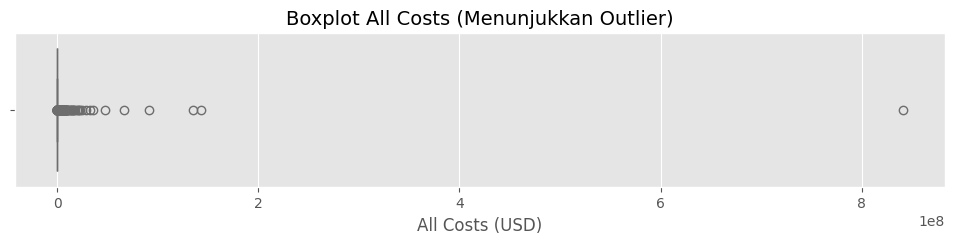

10 Insiden dengan Biaya Tertinggi:
 Report Number                        Operator Name  Accident Date/Time  All Costs
      20100181 ENBRIDGE ENERGY, LIMITED PARTNERSHIP 2010-07-25 17:58:00  840526118
      20150224                PLAINS PIPELINE, L.P. 2015-05-19 10:57:00  142931884
      20110262               EXXONMOBIL PIPELINE CO 2011-07-01 22:40:00  135000000
      20130151            MOBIL  PIPE  LINE COMPANY 2013-03-29 14:37:00   91300000
      20160324                 COLONIAL PIPELINE CO 2016-09-09 11:10:00   66234072
      20100221 ENBRIDGE ENERGY, LIMITED PARTNERSHIP 2010-09-09 11:30:00   47393566
      20110140               MARATHON PIPE LINE LLC 2011-04-13 18:58:00   35728903
      20100146                 CHEVRON PIPE LINE CO 2010-06-12 07:42:00   32233740
      20100124          ALYESKA PIPELINE SERVICE CO 2010-05-25 11:00:00   28938000
      20140393   CHEVRON PETROCHEMICAL PIPELINE LLC 2014-10-10 12:30:00   24323483


In [13]:
plt.figure(figsize=(12, 2))
sns.boxplot(x=df_model['All Costs'], color='salmon')
plt.title('Boxplot All Costs (Menunjukkan Outlier)', fontsize=14)
plt.xlabel('All Costs (USD)')
plt.show()


df_model['All Costs'] = pd.to_numeric(df_model['All Costs'], errors='coerce')
top_10_costs = df_model.sort_values(by='All Costs', ascending=False).head(10)
print("10 Insiden dengan Biaya Tertinggi:")
print(top_10_costs[['Report Number', 'Operator Name', 'Accident Date/Time', 'All Costs']].to_string(index=False))

Dapat dilihat data dengan nilai All Costs tertinggi sangat jauh dibandingkan data lainnya. Kita akan melakukan model alternatif dengan cara menghapus data tersebut. Penghapusan data sebenarnya tidak selalu menjadi solusi yang baik dalam pembuatan model, hal ini kita lakukan untuk membandingkan apakah dengan menghapus data ekstrim dapat lebih baik dalam memprediksi kasus secara umum.

In [14]:
# Total data
total_data = len(df_model)

# Hitung batas atas outlier menggunakan IQR (Interquartile Range)
Q1 = df_model['All Costs'].quantile(0.25)
Q3 = df_model['All Costs'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Buat dua subset: outlier dan non-outlier
outliers = df_model[df_model['All Costs'] > upper_bound]
non_outliers = df_model[df_model['All Costs'] <= upper_bound]

# Hitung jumlah masing-masing
total_outliers = len(outliers)
total_non_outliers = len(non_outliers)

# Hitung persentase
percentage_outliers = (total_outliers / total_data) * 100
percentage_non_outliers = (total_non_outliers / total_data) * 100

# Cetak hasil
print("Total data               :", total_data)
print("Jumlah data outlier      :", total_outliers)
print("Jumlah data non-outlier  :", total_non_outliers)
print(f"Persentase outlier       : {percentage_outliers:.2f}%")
print(f"Persentase non-outlier   : {percentage_non_outliers:.2f}%")

Total data               : 2795
Jumlah data outlier      : 418
Jumlah data non-outlier  : 2377
Persentase outlier       : 14.96%
Persentase non-outlier   : 85.04%


Dapat dilihat bahwa presentase data Outlier bisa dibilang tidak cukup besar. Kita dapat mencoba untuk menghapus seluruh data outlier dan membandingkan kualitas modelnya dengan sebelum menghapusnya.

In [15]:
# Salin DataFrame agar data asli tidak berubah
df_no_outlier = df_model.copy()

# Hitung IQR dan batas atas
Q1 = df_no_outlier['All Costs'].quantile(0.25)
Q3 = df_no_outlier['All Costs'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Filter hanya data yang bukan outlier
df_no_outlier = df_no_outlier[df_no_outlier['All Costs'] <= upper_bound]

# Tampilkan ringkasan hasil
print(f"Jumlah data awal         : {len(df_model)}")
print(f"Jumlah data setelah drop : {len(df_no_outlier)}")
print(f"Jumlah outlier dihapus   : {len(df_model) - len(df_no_outlier)}")

Jumlah data awal         : 2795
Jumlah data setelah drop : 2377
Jumlah outlier dihapus   : 418


In [16]:
# --- 1. Siapkan X dan y ---
features_to_exclude = ['Cost_per_Barrel_Lost', 'Avg_AllCosts_Operator']
predictor_cols = [col for col in predictor_cols if col not in features_to_exclude]
existing_cols = [col for col in predictor_cols if col in df_no_outlier.columns]
X = df_no_outlier[existing_cols].copy()
y = np.log1p(df_no_outlier['All Costs'].copy())  # Log transform target

# --- 2. Encoding ---
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
high_card, low_card = [], []
for col in cat_cols:
    if X[col].nunique() > 50 and col in ['Operator Name', 'Accident City']:
        high_card.append(col)
    else:
        low_card.append(col)

for col in high_card:
    freq_map = X[col].value_counts(normalize=True)
    X[col + '_freq_encoded'] = X[col].map(freq_map)
    X.drop(col, axis=1, inplace=True)

X = pd.get_dummies(X, columns=low_card, drop_first=True)

# --- 3. Split & Scale ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# --- 4. Train Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, min_samples_split=10, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, min_samples_split=10)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_log = model.predict(X_test_scaled)

    # Evaluasi pada skala log
    mae_log = mean_absolute_error(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    r2_log = r2_score(y_test, y_pred_log)

    # Kembalikan ke skala asli
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred_log)
    y_pred_orig[y_pred_orig < 0] = 0

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({
        "Model": name,
        "MAE (Log)": mae_log,
        "RMSE (Log)": rmse_log,
        "R² (Log)": r2_log,
        "MAE (USD)": mae,
        "RMSE (USD)": rmse,
        "R² (USD)": r2
    })

# --- 5. Tampilkan Hasil ---
results_df = pd.DataFrame(results)
results_df['MAE (USD)'] = results_df['MAE (USD)'].map('${:,.2f}'.format)
results_df['RMSE (USD)'] = results_df['RMSE (USD)'].map('${:,.2f}'.format)
results_df = results_df.round(4)

print("\n" + "="*30 + " Ringkasan Hasil Evaluasi Model " + "="*30)
print(results_df.to_string(index=False))



============================== Ringkasan Hasil Evaluasi Model ==============================
            Model  MAE (Log)  RMSE (Log)  R² (Log)  MAE (USD) RMSE (USD)  R² (USD)
Linear Regression     1.5046      2.0083    0.1105 $41,281.04 $88,976.76   -0.8343
    Decision Tree     1.7233      2.4402   -0.3131 $46,610.40 $76,904.13   -0.3703
    Random Forest     1.2546      1.7224    0.3457 $32,437.47 $61,117.38    0.1345
Gradient Boosting     1.2067      1.6378    0.4085 $33,240.10 $62,995.73    0.0805


In [17]:
df_no_outlier['All Costs'].describe()

count      2377.000000
mean      41282.323938
std       60047.754208
min           0.000000
25%        3904.000000
50%       15275.000000
75%       47000.000000
max      285500.000000
Name: All Costs, dtype: float64

Berdasarkan hasil evaluasi model yang menggunakan data tanpa outlier dapat dilihat bahwa error nya lebih baik dari sebelumnya. Akan tetapi perbandingan std fan mean nya tergolong buruk, yang menandakan kualitas datanya kurang baik. 

#### Tahap 3: Ringkasan dan Kesimpulan

Evaluasi performa model regresi telah dilakukan baik pada seluruh data maupun data tanpa outlier. Hasilnya menunjukkan bahwa penghapusan data outlier meningkatkan stabilitas dan keakuratan model, khususnya jika dilihat dari nilai MAE (Mean Absolute Error).

Model Random Forest menjadi yang paling unggul pada kondisi data tanpa outlier, dengan MAE hanya sekitar $32,437.47, jauh lebih rendah dan masuk akal dibandingkan saat menggunakan data penuh, di mana MAE-nya mencapai lebih dari $195,000. Hal ini menandakan bahwa tanpa adanya outlier ekstrem, model dapat mempelajari pola hubungan antara fitur dan target dengan lebih seimbang dan generalizable.

Namun, penghapusan outlier juga memiliki risiko dan konsekuensi. Data outlier bisa saja merepresentasikan kasus-kasus ekstrem yang valid dan penting dalam konteks risiko bisnis atau pengambilan keputusan kritis. Menghapusnya berarti model kehilangan kesempatan belajar dari skenario berdampak besar yang meskipun jarang, bisa sangat merugikan jika tidak terantisipasi.

Oleh karena itu, meskipun strategi penghapusan outlier membantu meningkatkan performa umum, penting juga untuk:

- Menyimpan salinan data outlier untuk dianalisis secara terpisah.

- Mengembangkan model khusus untuk kasus ekstrem (misalnya dengan teknik robust regression atau ensemble).

- Mengeksplorasi fitur lain

Kesimpulannya, penghapusan outlier meningkatkan performa model dari sisi MAE dan keandalan prediksi rata-rata, dan Random Forest terbukti menjadi model terbaik dalam kondisi ini. Pendekatan ini memberikan landasan yang kuat untuk memprediksi kerugian finansial akibat kecelakaan pipa secara lebih stabil, dan menjadi pondasi berharga untuk melanjutkan ke proyek klasifikasi penyebab utama kecelakaan pada tahap berikutnya.